# Comic Neural Style Transfer Demo

Demonstration of [neural style transfer](https://github.com/xunhuang1995/AdaIN-style) particularly [suitable for comic books](https://arxiv.org/pdf/1809.01726.pdf). Uses [SoS notebook](https://github.com/vatlab/sos-notebook) with [itorch kernel](https://github.com/facebookarchive/iTorch).

This implementation has the advantage for demos that it is very fast and displays steps graphically.

However [the original](https://github.com/xunhuang1995/AdaIN-style) is more flexible and useful in all other respects.

## Select Comic Style

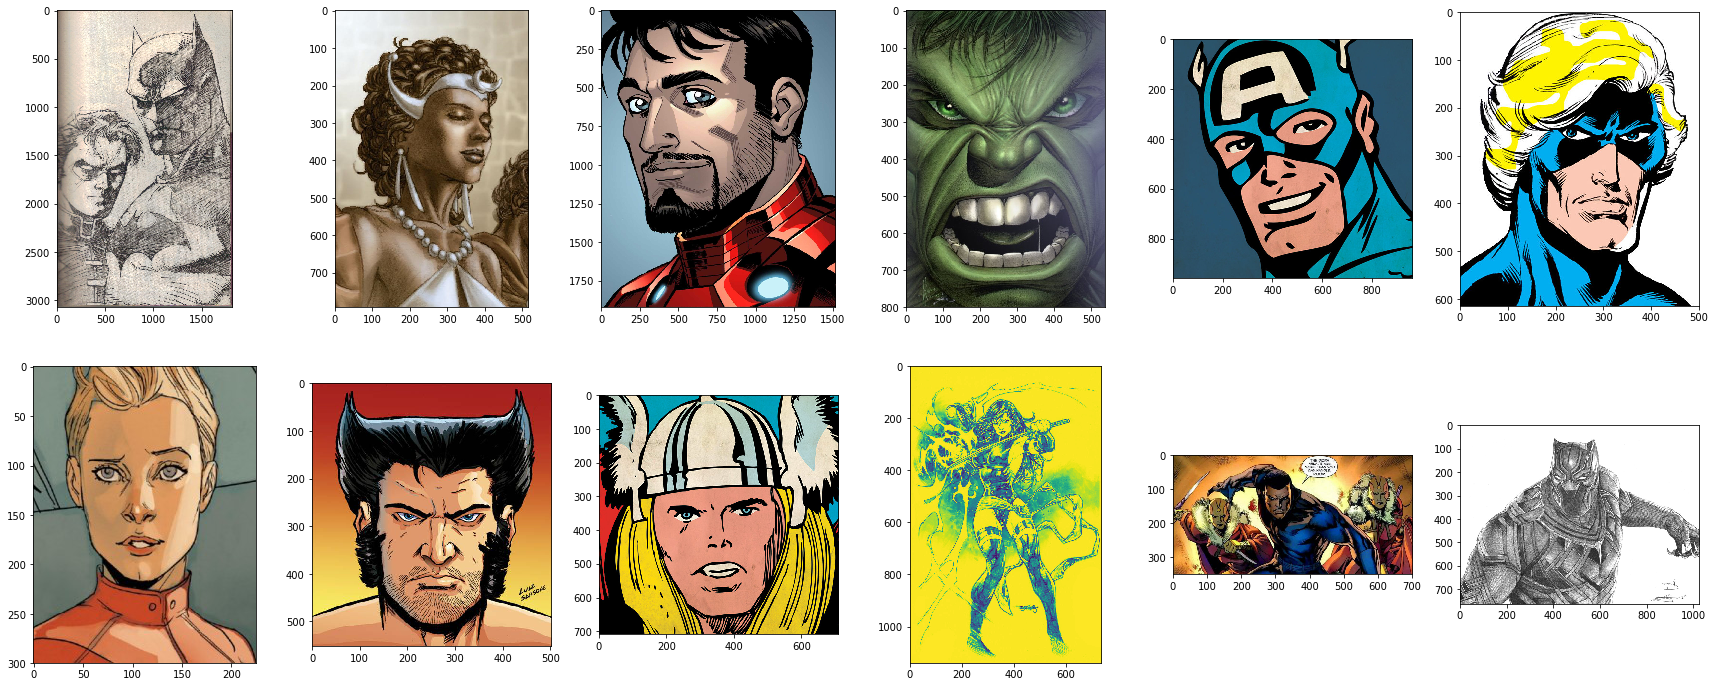

In [14]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from ipywidgets import interactive
from IPython.display import display
from shutil import copyfile

#Get a list of style files
imgs = []
for f in glob.glob('/z/aolney/repos/AdaIN-style/input/style/best-input/*.jpg'):
    img = mpimg.imread(f)
    imgs.append( (f,img) )
#display them
imax,jmax = 2,6 #hard coded dim
f,ax = plt.subplots(imax,jmax,figsize=(30, 12))
i,j = 0,0
for f,img in imgs:
    ax[i,j].imshow(img)
    if j < jmax - 1:
        j += 1
    else:
        j = 0
        i += 1

#Create an image chooser widget
def browse_images(imgs):
    n = len(imgs)
    def view_image(i):
        f,img = imgs[i]
        plt.imshow(img)
        plt.show()
        return f
    return interactive(view_image, i=(0,n-1))

In [15]:
# Choose one!
w = browse_images(imgs)
display(w)

interactive(children=(IntSlider(value=5, description='i', max=11), Output()), _dom_classes=('widget-interact',…

In [16]:
from IPython.display import Javascript, display
from ipywidgets import widgets

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

Button(description='Run all below', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#Save it
copyfile(w.result, '/z/aolney/repos/AdaIN-style/input/style/geek101-style.jpg')

'/z/aolney/repos/AdaIN-style/input/style/geek101-style.jpg'

## Acquire Content Image

Press 'q' to take picture from webcam

In [27]:
# No license: https://gist.github.com/cbednarski/8450931
import cv2
cap = cv2.VideoCapture(1) #Hard codes; not sure how to get a list of devices
while(True):
    ret, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)

    cv2.imshow('frame', rgb)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        out = cv2.imwrite('/z/aolney/repos/AdaIN-style/input/content/capture.jpg', frame)
        break

cap.release()
cv2.destroyAllWindows()

## Apply Deep Style Transfer

In [28]:
-- MIT License: https://github.com/xunhuang1995/AdaIN-style/blob/master/test.lua
require 'torch'
-- Cuda can be commented out on next three lines
-- require 'cutorch' -- not in original
-- require 'cudnn' -- not in original
-- require 'cunn' -- not in original
require 'nn'
require 'image'
require 'paths'
require 'lib/AdaptiveInstanceNormalization'
require 'lib/utils'


alpha = 1
vgg = torch.load('models/vgg_normalised.t7')
for i=53,32,-1 do
    vgg:remove(i)
end
local adain = nn.AdaptiveInstanceNormalization(vgg:get(#vgg-1).nOutputPlane)
decoder = torch.load('models/decoder.t7')

USECUDA = 0
if USECUDA == 1 then
    cutorch.setDevice(1) -- use nvidia-smi
    vgg = cudnn.convert(vgg, cudnn):cuda()
    adain:cuda()
    decoder:cuda()
else
    vgg:float()
    adain:float()
    decoder:float()
end
    
local function styleTransfer(content, style)
    if USECUDA == 1 then
        content = content:cuda()
        style = style:cuda()
    else
        content = content:float()
        style = style:float()
    end
    styleFeature = vgg:forward(style):clone()
    contentFeature = vgg:forward(content):clone()
    targetFeature = adain:forward({contentFeature, styleFeature})
    targetFeature = targetFeature:squeeze()
    targetFeature = alpha * targetFeature + (1 - alpha) * contentFeature
    return decoder:forward(targetFeature) 
end
paths.mkdir('geek101')
local contentPaths = {}
local stylePaths = {}
-- TODO: get camera image here or above
table.insert(contentPaths, '/z/aolney/repos/AdaIN-style/input/content/capture.jpg')
table.insert(stylePaths,'/z/aolney/repos/AdaIN-style/input/style/geek101-style.jpg')
local contentPath = contentPaths[1]
local contentExt = paths.extname(contentPath)
local contentImg = image.load(contentPath, 3, 'float')
local contentName = paths.basename(contentPath, contentExt)
local contentImg = sizePreprocess(contentImg, false, 512)
local stylePath = stylePaths[1]
styleExt = paths.extname(stylePath)
styleImg = image.load(stylePath, 3, 'float')
styleImg = sizePreprocess(styleImg, false, 512)
styleName = paths.basename(stylePath, styleExt)
local output = styleTransfer(contentImg, styleImg)
t = os.time(os.date("!*t"))
local savePath = paths.concat('geek101', t .. '.' .. 'jpg' )
    -- contentName .. '_stylized_' .. styleName .. '.' .. 'jpg')
image.save(savePath, output)

## View the Result

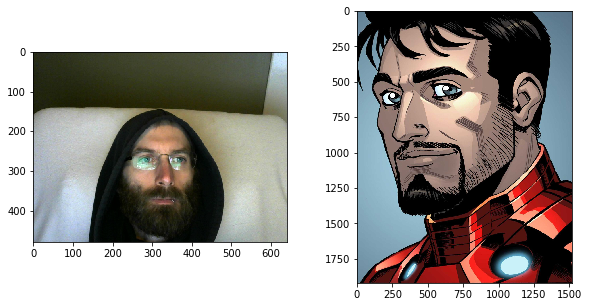

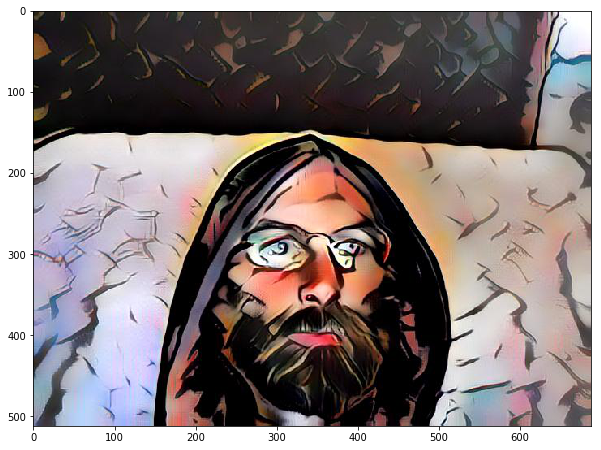

In [29]:
import os
result = os.listdir('/z/aolney/repos/AdaIN-style/geek101/')
result.sort() #hack we always display the last timestamped image
img = mpimg.imread('/z/aolney/repos/AdaIN-style/geek101/' + result[-1])
plt.figure(figsize=(10, 5))
content = mpimg.imread('/z/aolney/repos/AdaIN-style/input/content/capture.jpg') 
style = mpimg.imread('/z/aolney/repos/AdaIN-style/input/style/geek101-style.jpg')
plt.subplot(1, 2, 1)
plt.imshow(content)
plt.subplot(1, 2, 2)
plt.imshow(style)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('')
plt.show()